In [2]:

!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 44.9 MB/s 
     |████████████████████████████████| 596 kB 69.4 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install -q tensorflow-text==2.6.0

     |████████████████████████████████| 4.4 MB 4.5 MB/s 
     |████████████████████████████████| 570.3 MB 329 bytes/s 
     |████████████████████████████████| 462 kB 59.8 MB/s 
     |████████████████████████████████| 14.8 MB 42.5 MB/s 
     |████████████████████████████████| 1.3 MB 61.4 MB/s 
     |████████████████████████████████| 132 kB 72.5 MB/s 
     |████████████████████████████████| 5.6 MB 57.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
cmdstanpy 1.0.4 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.


In [5]:
import os
#import shutil
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [6]:
import json
import pandas as pd
import numpy as np
import os
import transformers
from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
f = open('/content/drive/MyDrive/data/data_full.json')
data = json.loads(f.read())

##Data exploration

In [9]:
data.keys()

dict_keys(['oos_val', 'val', 'train', 'oos_test', 'test', 'oos_train'])

In [31]:
# create DataFrame
train_data = []
train_class = []
test_data = []
test_class = []
val_data = []
val_class = []

for i in data['train']:
  train_data.append(i[0])
  train_class.append(i[1])

for i in data['test']:
  test_data.append(i[0])
  test_class.append(i[1])

for i in data['val']:
  val_data.append(i[0])
  val_class.append(i[1])


df_train = pd.DataFrame(list(zip(train_data,train_class)),
                        columns = ['text','class'])

df_test = pd.DataFrame(list(zip(test_data,test_class)),
                        columns = ['text','class'])

df_val = pd.DataFrame(list(zip(val_data,val_class)),
                        columns = ['text','class'])

In [32]:
print("Train data size {} \n Test data size {} \n Val data size {}".format(df_train.shape[0],df_test.shape[0],df_val.shape[0]))

Train data size 15000 
 Test data size 4500 
 Val data size 3000


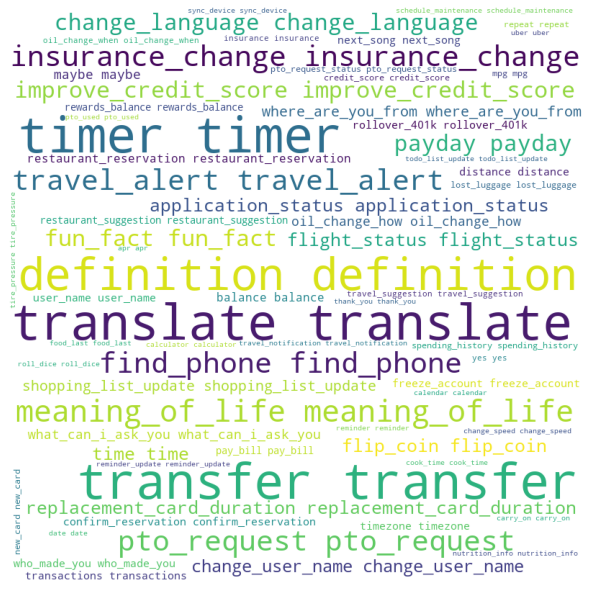

In [12]:
comment_words = ''
stopwords = set(STOPWORDS)

for val in df_train['class']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Preprocessing

In [18]:
df_train

,text,class
0,what expression would i use to say i love you ...,translate
1,can you tell me how to say 'i do not speak muc...,translate
2,"what is the equivalent of, 'life is good' in f...",translate
3,"tell me how to say, 'it is a beautiful morning...",translate
4,"if i were mongolian, how would i say that i am...",translate
...,...,...
14995,can you explain why my card was declined,card_declined
14996,how come starbucks declined my card when i tri...,card_declined
14997,how come my card was not accepted yesterday,card_declined
14998,find out what happened to make my card get dec...,card_declined


In [33]:
trainlabels=df_train.pop("class")

In [34]:
trainfeatures=df_train.copy()
trainfeatures=trainfeatures.values

In [35]:
from sklearn.preprocessing import LabelBinarizer

In [36]:
binarizer=LabelBinarizer()
trainlabels=binarizer.fit_transform(trainlabels.values)

In [37]:
trainlabels.shape

(15000, 150)

In [38]:
testfeatures=df_test.copy()

In [40]:
testlabels=testfeatures.pop("class")

In [41]:
validfeatures=df_val.copy()

In [42]:
validlabels=validfeatures.pop("class")

In [43]:
testfeatures=testfeatures.values
validfeatures=validfeatures.values

In [44]:
testlabels=binarizer.transform(testlabels.values)
validlabels=binarizer.transform(validlabels.values)

In [45]:
testlabels.shape

(4500, 150)

In [46]:
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8' 
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


In [47]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)


In [48]:
text_test = trainfeatures[0]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2054 3670 2052 1045 2224 2000 2360 1045 2293 2017 2065]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [49]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [50]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.35126176  0.006279   -0.99989283  0.29062265  0.21023782 -0.48445597
 -0.76332074 -0.2953436   0.31564564  0.09060848 -0.8633106  -0.2556615 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.11349763 -0.29797176  1.3307792  ... -1.0918118  -0.05384374
  -0.64917034]
 [ 0.26882517 -0.11792442 -1.1042697  ... -0.7519851   0.9297013
  -0.89285487]
 [-0.12542278  0.04376694  0.5652652  ... -0.5828283   0.54959327
  -0.37404943]
 ...
 [-0.72891057 -0.07490081  1.1228836  ... -0.5334061   0.50557494
  -1.0773985 ]
 [-0.45921862 -0.7026323   1.6991307  ... -0.9616932   0.40358156
   0.09007609]
 [-1.878255    0.1746958   1.7472062  ... -1.0660743   1.3269131
  -1.0178112 ]]


In [53]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(150, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [54]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(trainfeatures[0]))
print(tf.keras.activations.softmax(bert_raw_result))

tf.Tensor(
[[0.01545208 0.00375289 0.00509238 0.00523803 0.00330914 0.0019066
  0.00822889 0.00168167 0.00838624 0.00671651 0.01133414 0.01052683
  0.01221557 0.00699821 0.00660589 0.00823686 0.0054     0.00197466
  0.00329659 0.00462994 0.00572395 0.00399224 0.01243451 0.00246877
  0.0093888  0.00579046 0.00457262 0.01059197 0.00478846 0.00200037
  0.00442064 0.00271167 0.00787759 0.01016146 0.00417651 0.00152963
  0.00319485 0.00979613 0.00654391 0.00183111 0.00948958 0.00834615
  0.00286263 0.00851359 0.00779048 0.00861087 0.00761394 0.00392939
  0.00421108 0.00262226 0.01718411 0.00392677 0.02722511 0.00364729
  0.00295353 0.0091574  0.00944515 0.00143434 0.00465621 0.0071516
  0.0118015  0.00384588 0.00587012 0.00389948 0.00353871 0.00660097
  0.01106893 0.00335013 0.00291786 0.011951   0.00300793 0.00464965
  0.00420735 0.00554978 0.00654576 0.00459788 0.00091847 0.00682959
  0.00617544 0.00440255 0.01047652 0.00253519 0.00129165 0.00702488
  0.00723621 0.00541286 0.00274709 0.00

In [55]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.CategoricalAccuracy()

In [56]:
epochs=5
optimizer=tf.keras.optimizers.Adam(1e-5)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [57]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=trainfeatures,y=trainlabels,
                               validation_data=(validfeatures,validlabels),
                               batch_size=32,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/5
469/469 [==============================] - 186s 377ms/step - loss: 4.2001 - categorical_accuracy: 0.1947 - val_loss: 2.7127 - val_categorical_accuracy: 0.6377
Epoch 2/5
469/469 [==============================] - 182s 389ms/step - loss: 2.1242 - categorical_accuracy: 0.7369 - val_loss: 1.2927 - val_categorical_accuracy: 0.8330
Epoch 3/5
469/469 [==============================] - 180s 383ms/step - loss: 1.1265 - categorical_accuracy: 0.8720 - val_loss: 0.7553 - val_categorical_accuracy: 0.8850
Epoch 4/5
469/469 [==============================] - 180s 383ms/step - loss: 0.6758 - categorical_accuracy: 0.9255 - val_loss: 0.5158 - val_categorical_accuracy: 0.9130
Epoch 5/5
469/469 [==============================] - 180s 383ms/step - loss: 0.4403 - categorical_accuracy: 0.9511 - val_loss: 0.3957 - val_categorical_accuracy: 0.9310


In [58]:
loss, accuracy = classifier_model.evaluate(testfeatures,testlabels)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

141/141 [==============================] - 21s 148ms/step - loss: 0.3941 - categorical_accuracy: 0.9271
Loss: 0.39413362741470337
Accuracy: 0.9271110892295837


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


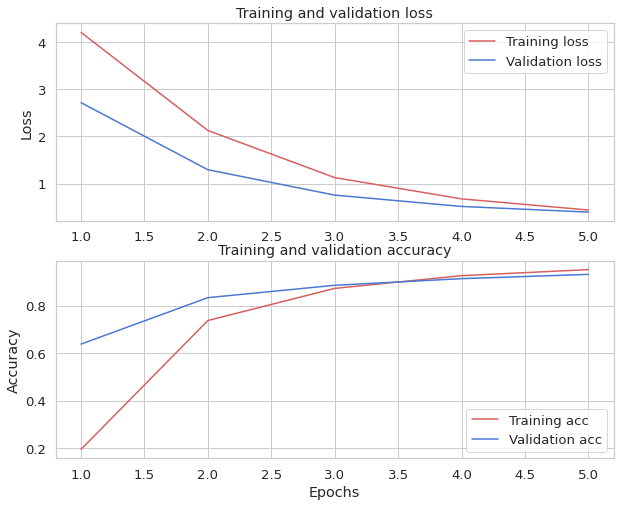

In [59]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(True)
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [61]:
y_pred = classifier_model.predict(testfeatures)

In [67]:
prediction = []
for i in y_pred:
  prediction.append(np.argmax(i))

In [70]:
true = []
for i in testlabels:
  true.append(np.argmax(i))

In [73]:
from sklearn.metrics import classification_report
print("Classification Report: \n", classification_report(true, prediction))

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.87      0.87      0.87        30
           2       0.88      1.00      0.94        30
           3       0.91      1.00      0.95        30
           4       0.91      1.00      0.95        30
           5       0.97      0.97      0.97        30
           6       0.93      0.93      0.93        30
           7       0.83      0.80      0.81        30
           8       0.96      0.83      0.89        30
           9       1.00      0.97      0.98        30
          10       0.97      1.00      0.98        30
          11       0.97      0.93      0.95        30
          12       0.90      0.60      0.72        30
          13       0.72      0.87      0.79        30
          14       0.97      0.97      0.97        30
          15       0.81      0.97      0.88        30
          16       1.00      1.00      1.00        30
  